# Working with Sequences


We start the practice by installing the book libraries and importing some of them:

In [2]:
%matplotlib inline
!pip install d2l==1.0.0a0
import torch
from torch import nn
from d2l import torch as d2l

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.6 MB/s eta 0:00:00


## Autoregressive Models

Our target data will be a synthetic data set built on the sinusoidal function
SIN.

We create 1000 data points within the DATA class but corrupt their values by adding some random noise.

self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2


We first define some initialization parameters:

Batch size=16

T=1000 (size of the sequence)

num_train (training samples)

tau = 4 (4 points will be used to estimate our next sample) (Markov problem of order 4)



In [3]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

Let's verify the type pof structure we are using (Torch Tensors)
and print the created data.

<class 'torch.Tensor'>
<class 'torch.Tensor'>


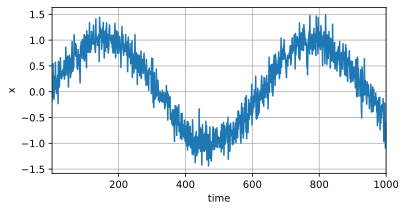

In [14]:
data = Data()
print(type(data.time))
print(type(data.x))
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

To begin, we try a model that acts as if
the data satisfied a $\tau^{\textrm{th}}$-order Markov condition,
and thus predicts $x_t$ using only the past $\tau$ observations. (We set it up originally to 4, you should try other values as well).

[**Thus for each time step we have an example
with label $y  = x_t$ and features
$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.**]


In [5]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

In this example our model will be a simple standard linear regression.
You can consult early chapters of the book "Dive into DL" (D2l)  to see some more details of it.
At this moment, we are not much interesting on the model used. We will
analyze relevant models later.

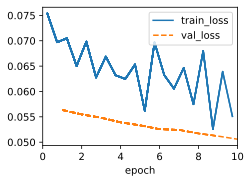

In [6]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Prediction

To evaluate our model, we first check
how well it performs at one-step-ahead prediction.


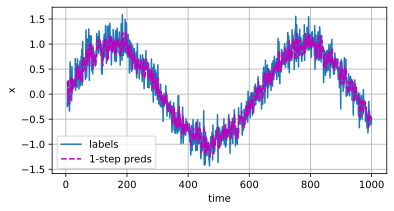

In [7]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

These predictions look good,
even near the end at $t=1000$.

But what if we only observed sequence data
up until time step 604 (`n_train + tau`)
and wished to make predictions several steps
into the future?
Unfortunately, we cannot directly compute
the one-step-ahead prediction for time step 609,
because we do not know the corresponding inputs,
having seen only up to $x_{604}$.
We can address this problem by plugging in
our earlier predictions as inputs to our model
for making subsequent predictions,
projecting forward, one step at a time,
until reaching the desired time step:

$$\begin{aligned}
\hat{x}_{605} &= f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} &= f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} &= f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} &= f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} &= f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
&\vdots\end{aligned}$$

Generally, for an observed sequence $x_1, \ldots, x_t$,
its predicted output $\hat{x}_{t+k}$ at time step $t+k$
is called the $k$*-step-ahead prediction*.
Since we have observed up to $x_{604}$,
its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to
keep on using our own predictions
to make multistep-ahead predictions.
Let's see how well this goes.


In [8]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

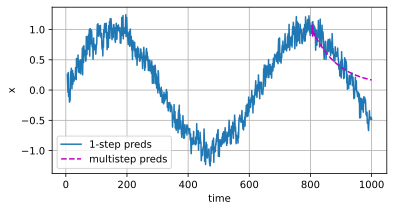

In [9]:
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

Unfortunately, in this case we fail spectacularly.
The predictions decay to a constant
pretty quickly after a few steps.
Why did the algorithm perform so much worse
when predicting further into the future?
Ultimately, this is down to the fact
that errors build up.
Let's say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$,
hence we suffer some error in the order of
$\epsilon_2 = \bar\epsilon + c \epsilon_1$
for some constant $c$, and so on.
The predictions can diverge rapidly
from the true observations.
You may already be familiar
with this common phenomenon.
For instance, weather forecasts for the next 24 hours
tend to be pretty accurate but beyond that,
accuracy declines rapidly.
We will discuss methods for improving this
throughout this chapter and beyond.

Let's [**take a closer look at the difficulties in $k$-step-ahead predictions**]
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.


In [15]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

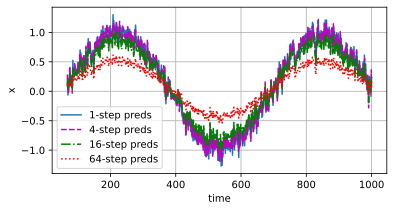

In [16]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes
as we try to predict further into the future.
While the 4-step-ahead predictions still look good,
anything beyond that is starts to get worse.


## P0-Exercises

1. Improve the model in the experiment of this section. Modify the number of past observations used for predictions. What seems to be the optimal value? Justify.

2. With a chosen value of $\tau$ compare results for future predictions at different times, showing the error obtained.

3. Repeat the whole analysis with a real data set:
Option a) ibm.us.txt : Stock Market predictions
Option b) daily-min-temperaturas.csv : Daily Temperature values
Extract conclusions. Compute the MSE o MAE for different cases.

4. Theory: Autoregressive vs Autoregressive latent models. Look for an example that might need latent variables to capture the dynamic of the data. Explain.

